In [13]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pandas as pd
import csv

In [14]:
df = pd.read_csv("../data/SMSSpamCollection.csv", sep = "\t", header = None, names = ["label", "text"], encoding="utf-8", engine="python", quoting=csv.QUOTE_NONE)

df["label"] = df["label"].astype(str).str.replace('"', '').str.strip()
df.head()

print(df["label"].unique())
print(df["text"].isna().mean())
df["label"].value_counts()

<StringArray>
['ham', 'spam']
Length: 2, dtype: str
0.0


label
ham     4827
spam     747
Name: count, dtype: int64

In [15]:
X = df["text"]
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=45, stratify=y
)

clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        min_df=2
    )),
    ("model", LogisticRegression(max_iter=2000))
])

clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


Accuracy:  0.9659192825112107
F1 (spam positive):  0.8549618320610687
ROC-AUC:  0.9940875679130713


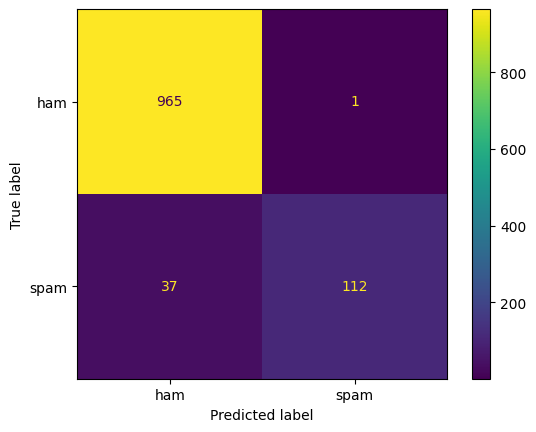

In [16]:
y_pred = clf.predict(X_val)
proba = clf.predict_proba(X_val)

spam_idx = list(clf.named_steps["model"].classes_).index("spam")

y_proba_spam = proba[:, spam_idx]

print("Accuracy: ", accuracy_score(y_val, y_pred))
print("F1 (spam positive): ", f1_score((y_val == "spam"), (y_pred == "spam")))
print("ROC-AUC: ", roc_auc_score((y_val == "spam"), y_proba_spam))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()

In [17]:
from sklearn.metrics import precision_score, recall_score

y_true_spam = (y_val == "spam")
y_pred_spam = (y_pred == "spam")

print("Precision (spam): ", precision_score(y_true_spam, y_pred_spam))
print("Recall (spam): ", recall_score(y_true_spam, y_pred_spam))

Precision (spam):  0.9911504424778761
Recall (spam):  0.7516778523489933


In [18]:
errors_fn = df.loc[X_val.index[(y_val == "spam") & (y_pred == "ham")], ["label", "text"]]
errors_fn.head(10)

,label,text
1097,spam,Dear Subscriber ur draw 4 £100 gift voucher wi...
3005,spam,You've won tkts to the EURO2004 CUP FINAL or £...
2663,spam,Hello darling how are you today? I would love ...
2109,spam,FREE2DAY sexy St George's Day pic of Jordan!Tx...
3620,spam,8007 25p 4 Alfie Moon's Children in Need song ...
5372,spam,dating:i have had two of these. Only started a...
5071,spam,5p 4 alfie Moon's Children in need song on ur ...
2145,spam,FreeMsg: Hey - I'm Buffy. 25 and love to satis...
1430,spam,For sale - arsenal dartboard. Good condition b...
1252,spam,Please CALL 08712402779 immediately as there i...


In [ ]:
errors_fp = df.loc[X_val.index[(y_val == "ham") & (y_pred == "spam")], ["label", "text"]]
errors_fp.head(10)

,label,text
4702,ham,"I liked the new mobile"""


In [21]:
import numpy as np

vectorizer = clf.named_steps["tfidf"]
model = clf.named_steps["model"]

feature_names = np.array(vectorizer.get_feature_names_out())
coef = model.coef_[0]

spam_idx = list(model.classes_).index("spam")
spam_coef = coef if spam_idx == 1 else -coef

top_spam = feature_names[np.argsort(spam_coef)[-20:]][::-1]
top_ham = feature_names[np.argsort(spam_coef)[:20]]

print("Top spam indicators: ", top_spam)
print("Top ham indicators: ", top_ham)

Top spam indicators:  ['txt' 'mobile' 'claim' 'uk' 'free' 'www' 'stop' '150p' 'text' '50'
 'service' 'reply' 'prize' 'com' 'new' '18' 'win' 'ringtone' 'cash'
 'urgent']
Top ham indicators:  ['ok' 'll' 'come' 'home' 'da' 'lt' 'gt' 'got' 'lor' 'later' 'lt gt' 'good'
 'going' 'sorry' 'way' 'hey' 'oh' 'think' 'like' 'don']
